In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from config.plotting import set_plotting_defaults
from config.units import Gauss
from src.electron_spectrum_parametrization import SpectrumParametrization

In [2]:
set_plotting_defaults()

First synchrotron function by definition:
$$ F(x) = x\intop_{x}^{\infty}K_{5/3}(t)\,dt = x \intop_{x}^{\infty} t K_{5/3}(t) \,d\ln{t} $$

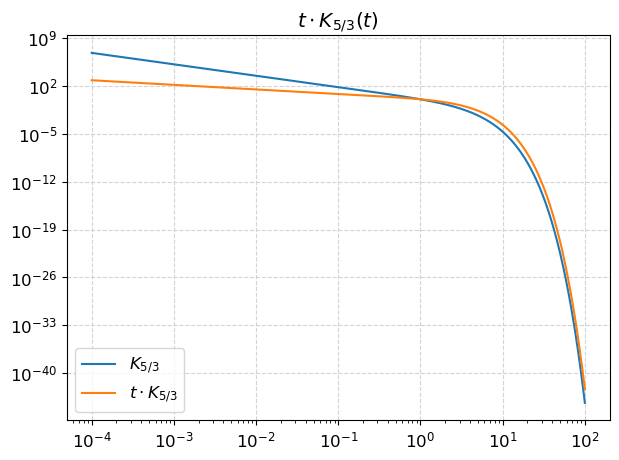

In [3]:
from scipy.special import kv

t = np.logspace(-4, 2, 1000)
K53 = kv(5/3, t)
plt.title(r"$t \cdot K_{5/3}(t)$")
plt.loglog(t, K53, label=r'$K_{5/3}$')
plt.loglog(t, t * K53, label=r'$t \cdot K_{5/3}$')
plt.legend(loc=3)
plt.show()

In [4]:
def first_synchrotron_function(x1):
    t1 = np.logspace(np.log10(x1), 2.2, 1200)
    ln_t1 = np.log(t1)
    k1 = kv(5/3, t1)
    return np.trapezoid(t1 * k1, ln_t1) * x1


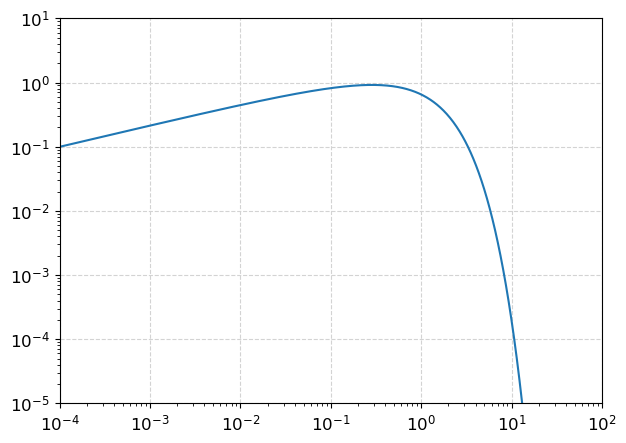

In [5]:
x = np.logspace(-4, 2, 1000)

fsf = np.ones_like(x)

for i in range(len(x)):
    fsf[i] = first_synchrotron_function(x[i])

plt.loglog(x, fsf)
plt.ylim(1e-5, 1e1)
plt.xlim(1e-4, 1e2)
plt.show()

First Synchrotron function as givem by Fouka and Ouichaoui (2013)

$$ F(x) = F_1(x) \cdot \delta_1(x) + F_2(x) \cdot \delta_2(x) $$

<Figure size 800x800 with 0 Axes>

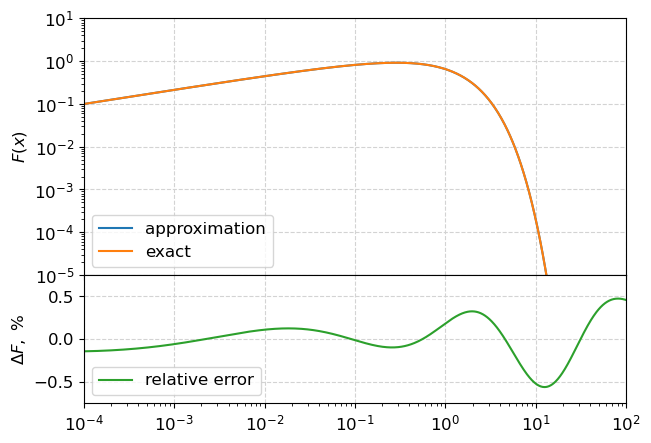

In [6]:
from config.plotting import Tab10
from src.synchrotron_emission import first_synchrtoron_function_approximation


x = np.logspace(-4, 2, 1000)
fsf_a = first_synchrtoron_function_approximation(x)

fig = plt.figure(figsize=(8, 8))

gridspec_kw = dict(height_ratios=[2, 1],
                   hspace=0)

_, axes = plt.subplots(
    nrows=2, ncols=1, sharex=True, gridspec_kw=gridspec_kw,
)

ax1 = axes[0]
ax1.loglog(x, fsf_a, label='approximation')
ax1.loglog(x, fsf, label='exact')
ax1.legend(loc=3)
ax1.set_ylim(1e-5, 1e1)
ax1.set_xlim(1e-4, 1e2)
ax1.set_ylabel(r'$F(x)$')

ax2 = axes[1]
ax2.plot(x, -100 * (fsf_a - fsf) / fsf, label='relative error', color=Tab10[2])
ax2.set_ylabel(r'$\Delta F,$ %')
ax2.set_ylim(-0.75, 0.75)
ax2.legend(loc=3)
plt.show()

## Synchrotron emission spectra for single electrons

In [7]:
import astropy.units as u
from src.synchrotron_emission import single_electron_synchrotron_emission_power

from config.units import Gauss

(1e-08, 1e+16)

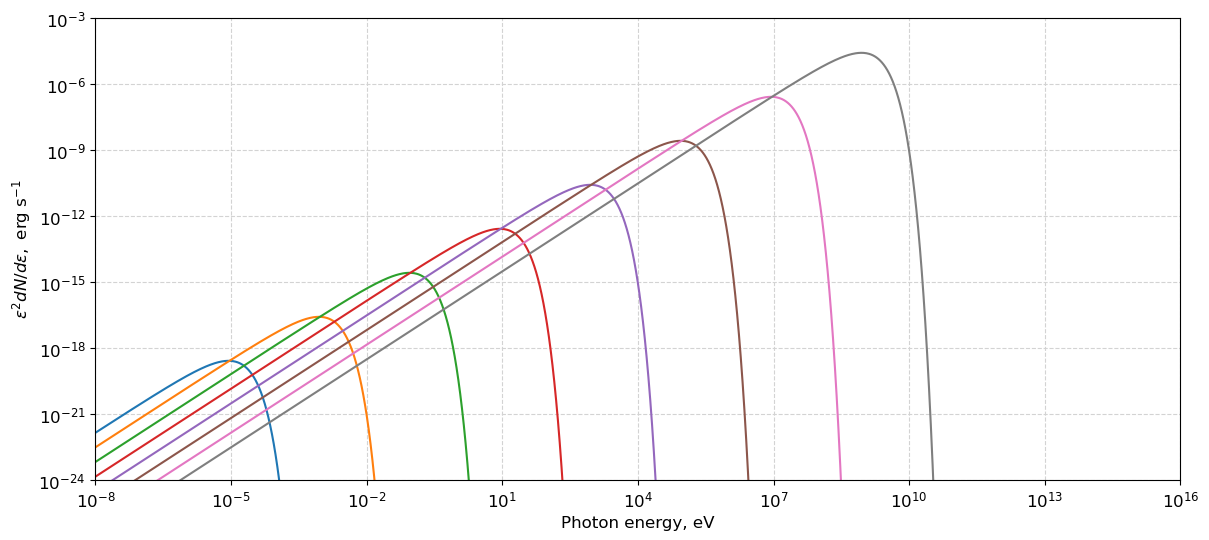

In [19]:
electron_energy = np.logspace(10, 17, 8) * u.eV  # electron energies
photon_energy = np.logspace(-8, 12, 1000) * u.eV  # photon energies
bfield = 1e-6 * Gauss

plt.figure(figsize=(14, 6))
for i, e_i in enumerate(electron_energy):
    sese_i = single_electron_synchrotron_emission_power(e_i, photon_energy, bfield).to(u.erg/(u.eV * u.s))
    plt.loglog(photon_energy, photon_energy * sese_i, label=f"{e_i.value:.2g} eV")

plt.ylim(1e-24, 1e-3)
plt.ylabel(r"$\epsilon^2 dN/d\epsilon,~\mathrm{erg~s^{-1}}$")
plt.xlabel(r"Photon energy, eV")
plt.xlim(1e-8, 1e16)

Now compare it with inverse Compton on CMB

In [76]:
from src.klein_nishina import klein_nishina_on_CMB
from config.constants import CST_m_e

(1e-08, 1e+17)

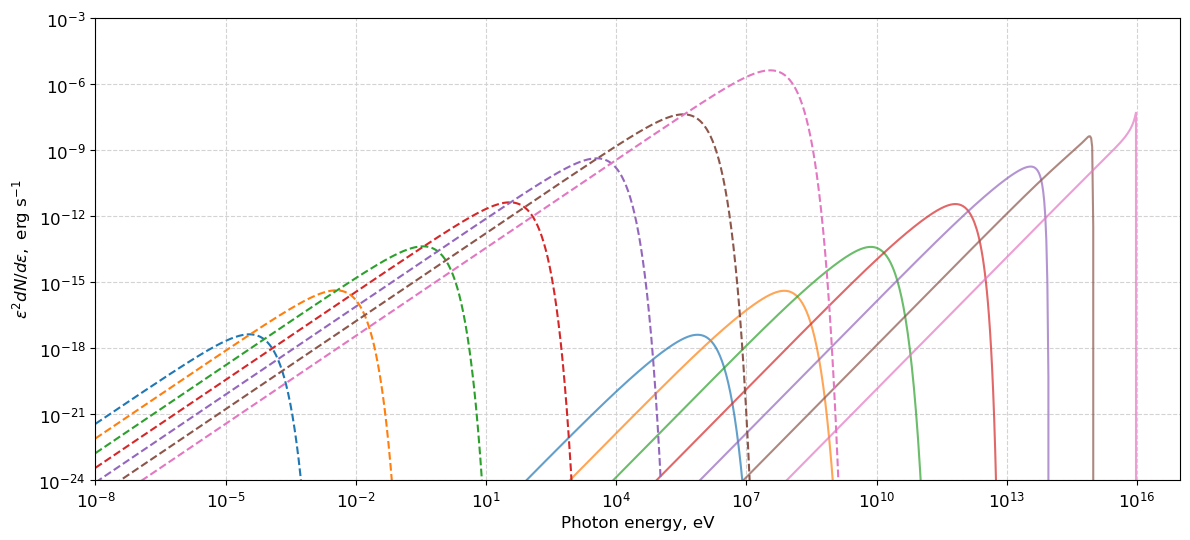

In [77]:
electron_energy = np.logspace(10, 16, 7) * u.eV  # electron energies
photon_energy = np.logspace(-8, 16, 1000) * u.eV  # photon energies
bfield = 4e-6 * Gauss

rad_unit = u.erg / u.s

plt.figure(figsize=(14, 6))
for i, e_i in enumerate(electron_energy):
    sese_i = single_electron_synchrotron_emission_power(e_i, photon_energy, bfield).to(u.erg/(u.eV * u.s))
    g_i = e_i / CST_m_e
    ic_i = klein_nishina_on_CMB(g_i, photon_energy).to(1/(u.eV * u.s))
    plt.loglog(photon_energy, (photon_energy * sese_i).to(rad_unit), label=f"{e_i.value:.2g} eV",
               color=Tab10[i % len(Tab10)], linestyle='dashed')
    plt.loglog(photon_energy, (photon_energy**2 * ic_i).to(rad_unit), label=f"{e_i.value:.2g} eV, IC",
               color=Tab10[i % len(Tab10)], linestyle='solid', alpha=.7)

plt.ylim(1e-24, 1e-3)
plt.ylabel(r"$\epsilon^2 dN/d\epsilon,~\mathrm{erg~s^{-1}}$")
plt.xlabel(r"Photon energy, eV")
plt.xlim(1e-8, 1e17)

#### Finally, one can do an electron-spectrum calculation

Spectrum parameters are chosen complementary to [Suzuki, 2025].

In [90]:
from src.electron_spectrum_parametrization import SpectrumParametrization

sp = SpectrumParametrization(n0=1e-26 * u.cm**(-3), e0=1e12 * u.eV,
                             eta0=0.0, p0=2.0, k10=-20.0, k20=np.log10(50))

n_el, n_phot = 200, 120
electron_energy = np.logspace(6, 17, n_el) * u.eV
photon_energy = np.logspace(-8, 17, n_phot) * u.eV

electron_density = sp.dn_de0(electron_energy)

synch = np.zeros([n_el, n_phot]) * rad_unit
compt = np.zeros([n_el, n_phot]) * rad_unit

for i, e_i in enumerate(electron_energy):
    # synchrotron emission
    synch[i, :] = photon_energy * single_electron_synchrotron_emission_power(e_i, photon_energy, bfield)

    # inverse Compton on CMB
    g_i = e_i / CST_m_e
    compt[i, :] = photon_energy**2 * klein_nishina_on_CMB(g_i, photon_energy).to(1/(u.eV * u.s))

In [91]:
synch_full = np.trapezoid(synch.T * sp.dn_de0(electron_energy), electron_energy, axis=1)
compt_full = np.trapezoid(compt.T * sp.dn_de0(electron_energy), electron_energy, axis=1)

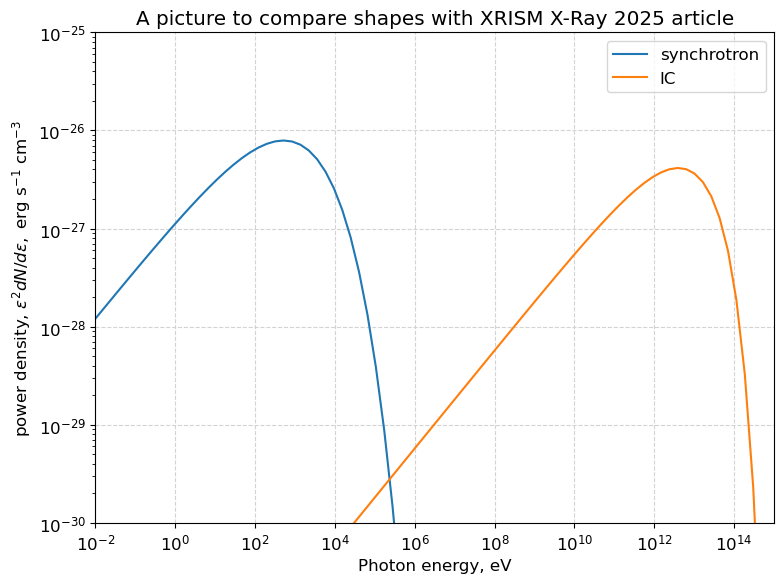

In [97]:
plt.figure(figsize=(8, 6))
plt.loglog(photon_energy, synch_full, label='synchrotron')
plt.loglog(photon_energy, compt_full, label='IC')

plt.xlim(1e-2, 1e15)
plt.xlabel(r"Photon energy, eV")

plt.ylim(1e-30, 1e-25)
plt.ylabel(r"power density, $\epsilon^2 dN/d\epsilon,~\mathrm{erg~s^{-1}~cm^{-3}}$")

plt.title("A picture to compare shapes with XRISM X-Ray 2025 article")
plt.legend()
plt.tight_layout()
# plt.savefig('synchrotron_emission.png', dpi=300, transparent=True)
plt.show()